In [1]:

import DW_oscillator as DW
import numpy as np
from IPython.display import clear_output

from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [17]:
torch.manual_seed(7)

"run_field_sequence" that randomly generates and simulates a set of fields. It returns the time, DW position and angle plus the input time sequence.
field_low and field_high specify the range the fields will be generated over while N_fields is the number of fields in the sequence and T is the time period of each field.

The outputs of interest are t, y and h_t. y[0] is the DW position over time (at time points given in t) and h_t is the magnetic field (serves as input) at the same times.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
t, y, h_t, fields, periods = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 60,y0 = [60.0,0.0])

[100.]
[60.]


In [19]:
t.shape,y.shape,h_t.shape,fields.shape,periods.shape

((600,), (2, 600), (600,), (1,), (1,))

In [20]:
fields,periods

(array([100.]), array([60.]))

In [9]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(2, 64)
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128,256)
        self.lin4 = nn.Linear(256,2)
        self.tanh = nn.Tanh()
        

    def forward(self, t,x):
        f = 0.5
        omega = 2*np.pi*f
        h_app(t) = h* np.sin(omega*t)
        x = self.tanh(self.lin(x))
        x = self.tanh(self.lin2(x))
        x = self.tanh(self.lin3(x))
        x = self.lin4(x)
        return x
     

In [44]:
out = torch.tensor([[1.0, 2.0, 3.0],[4.0,5.0,6.0]])

In [33]:
out.shape

torch.Size([2, 3])

In [34]:
indices = [1,2]

In [45]:
out = out.gather(1, torch.tensor([[0, 2], [1, 0]]))

In [46]:
out

tensor([[1., 3.],
        [5., 4.]])

In [7]:
f = 0.5
omega = 2*np.pi*f
h_app = 0.3* np.sin(omega*t)

In [14]:
h_t[:t[-1]]

TypeError: slice indices must be integers or None or have an __index__ method

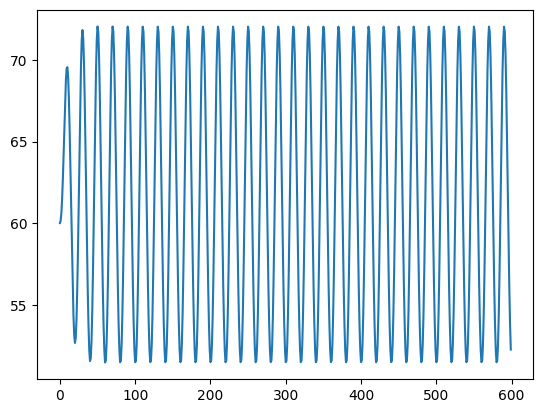

In [10]:
plt.plot(y[0])

In [11]:
y.shape

(2, 600)

In [35]:
time = torch.tensor(t).to(device)

In [36]:
time.shape

torch.Size([600])

In [14]:
time_train = torch.tensor(t[:400]).to(device)

In [15]:
time_test = torch.tensor(t[400:]).to(device)

In [16]:
time_train.shape,time_test.shape

(torch.Size([400]), torch.Size([200]))

In [22]:
h_t_ = torch.tensor(h_t, dtype=torch.float64)  # Converting to column vector
y_0_ = torch.tensor(y[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data = torch.stack((torch.div(h_t_, 1000.),torch.div(y_0_, 1000.), y_1_)).to(device)

In [25]:
data.shape

torch.Size([3, 600])

In [26]:
train = data[:,:400].transpose(0,1)

In [28]:
test = data[:,400:].transpose(0,1)

In [29]:
train.shape,test.shape

(torch.Size([400, 3]), torch.Size([200, 3]))

In [72]:
model = DWODE().double().to(device)

In [73]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [34]:
def get_batch(true_y,time, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    #print(indices)
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0,batch_t,batch_y

In [33]:
from torchdiffeq import odeint_adjoint as adjoint

In [66]:
loss_threshold = 0.00051

In [ ]:
min_loss = 1.0

In [69]:
i = 0
while min_loss > loss_threshold and i < 2000:
   
    optimizer.zero_grad()
    
    init,batch_t,truth = get_batch(train,time_train,8)
    #print(init,batch_t,truth)
    pred_y = adjoint(model,init,batch_t,method='dopri5')
    loss = F.mse_loss(pred_y, truth)
    loss.backward()
    
    optimizer.step()
   
    i +=1
    if i % 100 == 0:
        with torch.no_grad():
            pred_y = adjoint(model, train[0], time_train,method='dopri5')
            loss = F.mse_loss(pred_y, train)
            
            if loss.item() < min_loss:
                min_loss = loss.item()
            
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            x_pred = pred_y[:,0].cpu()
            y_pred = pred_y[:,1].cpu()
            z_pred = pred_y[:,2].cpu()

            # Extract the x, y, z coordinates from X_train_plt
            x_train = train[:,0].cpu()
            y_train = train[:,1].cpu()
            z_train = train[:,2].cpu()

            fig, ax = plt.subplots(3, 1, figsize=(5, 5))
            ax[0].plot(x_train, label='True')
            ax[0].plot(x_pred, label='Predicted', linestyle='--')
            ax[0].set_ylabel('H_T')
            ax[0].set_title('Projection')
            ax[0].legend()

            ax[1].plot(y_train, label='True')
            ax[1].plot(y_pred, label='Predicted',linestyle='--')
            ax[1].set_ylabel('Y[0]')
            ax[1].set_title('Projection')
            ax[1].legend()

            ax[2].plot(z_train, label='True')
            ax[2].plot(z_pred, label='Predicted',linestyle='--')
            ax[2].set_ylabel('Y[1]')
            
            ax[2].set_title('Projection')
            ax[2].legend()

            plt.tight_layout()
            plt.show()
            clear_output(wait=True)

In [59]:
with torch.no_grad():
    pred = odeint(model, train[0], time)
  

In [60]:
pred = pred.cpu().detach().numpy()

In [54]:
pred.shape,data.shape

((400, 3), torch.Size([600, 3]))

In [45]:
data = data.transpose(0,1)

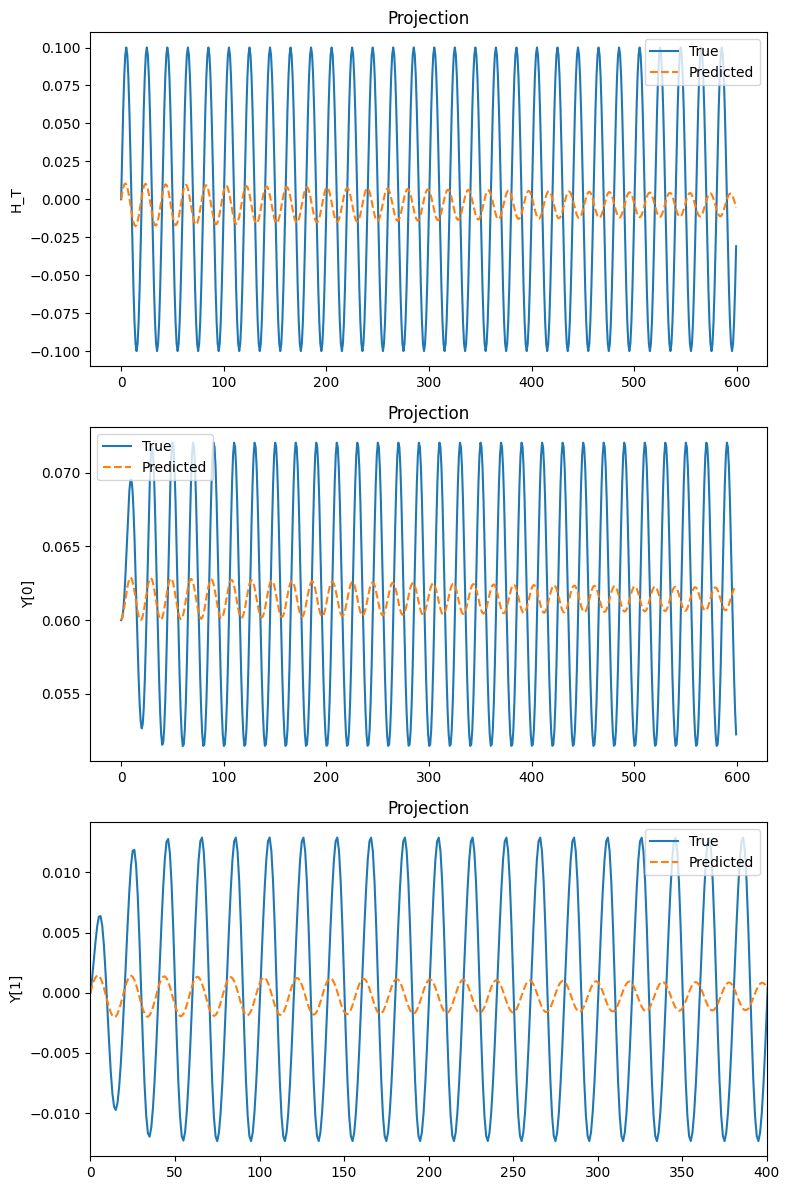

In [62]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]
z_pred = pred[:,2]

# Extract the x, y, z coordinates from X_train_plt
x_train = data[:,0].cpu()
y_train = data[:,1].cpu()
z_train = data[:,2].cpu()

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
# ax[0].set_xlim(0, 200)
# ax[0].set_ylim(0, 300)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred, label='Predicted',linestyle='--')
ax[2].set_ylabel('Y[1]')
ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()
#plt.savefig('projection_max_steps.png')
plt.tight_layout()
plt.show()